In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir('/content/gdrive/My Drive/FYP/Speaker/Triplet')
os.environ['TF_CPP_MIN_LOG_LEVEL']= '3'

import tensorflow as tf
tf.autograph.set_verbosity(0)

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from siamese import Siamese
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

In [4]:
MODEL_PATH = 'Model/LSTM/'
CORE_PATH = '../Classification/Model/LSTM/'
DATA_PATH = '../Data/Data/'

In [5]:
print('Loading data')
with open(DATA_PATH + 'train.pickle', 'rb') as f:
    X_train, s_train = pickle.load(f)
with open(DATA_PATH + 'val.pickle', 'rb') as f:
    X_val, s_val = pickle.load(f)

Loading data


In [6]:
def get_triplet(X, s):
    speakers = list(s.keys())
    num = len(speakers)
    
    s1 = np.random.randint(0, num)
    s2 = np.random.randint(0, num)
    while s1 == s2:
        s2 = np.random.randint(0, num)
    
    l1, h1 = s[speakers[s1]]
    l2, h2 = s[speakers[s2]]
    
    i1_1 = np.random.randint(l1, h1+1) - l1
    i1_2 = np.random.randint(l1, h1+1) - l1
    while i1_2 == i1_1:
        i1_2 = np.random.randint(l1, h1+1) - l1
    
    i2 = np.random.randint(l2, h2+1) - l2
    
    a = abs(X[s1][i1_1])
    p = abs(X[s1][i1_2])
    n = abs(X[s2][i2])
    
    return a.reshape(W, H, 1), p.reshape(W, H, 1), n.reshape(W, H, 1)

def get_batch(X, s, batch_size):
    anchor = []
    positive = []
    negative = []
    
    for _ in range(batch_size):
        a, p, n = get_triplet(X, s)
        anchor.append(a)
        positive.append(p)
        negative.append(n)
        
    anchor, positive, negative = np.array(anchor), np.array(positive), np.array(negative)
    _ = np.random.permutation(len(anchor))
    return [anchor[_], positive[_], negative[_]]

In [7]:
def train_generator(batch_size, encoding_dim):
    while True:
        X = get_batch(X_train, s_train, batch_size)
        y = np.zeros((batch_size, 3*encoding_dim))
        yield X, y
        
def val_generator(batch_size, encoding_dim):
    while True:
        X = get_batch(X_val, s_val, batch_size)
        y = np.zeros((batch_size, 3*encoding_dim))
        yield X, y

In [8]:
BATCH_SIZE = 256
MARGIN = 1
LR = 0.0006
W = 300
H = 128
EPOCHS = 50
STEPS_PER_EPOCH = 100
VALIDATION_STEPS = 50
ENCODING_DIM = 128

In [9]:
def train(model):
    filepath = MODEL_PATH + 'lstm_{epoch:02d}.h5'
    checkpoint = ModelCheckpoint(filepath, save_weights_only=True, period=10)
    history = model.model.fit(train_generator(BATCH_SIZE, ENCODING_DIM), epochs=EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH, callbacks=[checkpoint],
                              validation_data=(val_generator(BATCH_SIZE, ENCODING_DIM)),
                              validation_steps=VALIDATION_STEPS, shuffle=True)
                              
    return history

In [10]:
print('Creating Model')
model = Siamese((W, H, 1), name='lstm', lr=LR, margin=MARGIN, core_path=CORE_PATH+'lstm_20.h5')
model.model.summary()

Creating Model
Model: "output"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 128, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 300, 128, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 300, 128, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          2569152     input_1[0][0]                    
                                                                 input_2[0][0]

In [11]:
history = train(model)

Epoch 1/50
100/100 [==============================] - 42s 284ms/step - loss: 0.7633 - val_loss: 0.4923
Epoch 2/50
100/100 [==============================] - 26s 257ms/step - loss: 0.4544 - val_loss: 0.4701
Epoch 3/50
100/100 [==============================] - 26s 259ms/step - loss: 0.4328 - val_loss: 0.4926
Epoch 4/50
100/100 [==============================] - 26s 258ms/step - loss: 0.3944 - val_loss: 0.4649
Epoch 5/50
100/100 [==============================] - 26s 260ms/step - loss: 0.4051 - val_loss: 0.4340
Epoch 6/50
100/100 [==============================] - 26s 258ms/step - loss: 0.3735 - val_loss: 0.4428
Epoch 7/50
100/100 [==============================] - 26s 262ms/step - loss: 0.3518 - val_loss: 0.4157
Epoch 8/50
100/100 [==============================] - 26s 262ms/step - loss: 0.3599 - val_loss: 0.4103
Epoch 9/50
100/100 [==============================] - 26s 260ms/step - loss: 0.3452 - val_loss: 0.4410
Epoch 10/50
100/100 [==============================] - 26s 263ms/step - l

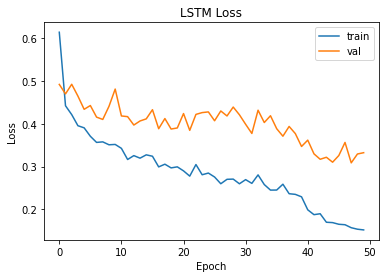

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [13]:
with open(MODEL_PATH + 'lstm_history.pickle', 'wb') as f:
    pickle.dump(history.history, f)